# Download Dataset using Kaggle API 

In [0]:
!pip install kaggle

In [0]:
import json
token = {"username":"rswain1486","key":"2201578abbdc9ed6b763709ef9e6765a"}
with open("/root/.kaggle/kaggle.json", "w") as file:
    json.dump(token, file)

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [0]:
!kaggle competitions download -c plant-seedlings-classification

  0% 0.00/5.13k [00:00<?, ?B/s]
100% 5.13k/5.13k [00:00<00:00, 4.15MB/s]
 94% 81.0M/86.0M [00:01<00:00, 45.1MB/s]
100% 86.0M/86.0M [00:01<00:00, 63.5MB/s]
100% 1.59G/1.60G [00:20<00:00, 117MB/s]
100% 1.60G/1.60G [00:20<00:00, 83.2MB/s]


In [0]:
from distutils.dir_util import copy_tree

In [0]:
!mkdir /content/competitions

In [0]:
fromDirectory = "/content/backup/content/competitions"
toDirectory = "/content/competitions"

copy_tree(fromDirectory, toDirectory)

['/content/competitions/plant-seedlings-classification/train.zip',
 '/content/competitions/plant-seedlings-classification/sample_submission.csv.zip',
 '/content/competitions/plant-seedlings-classification/test.zip']

In [0]:
cd /content/competitions/plant-seedlings-classification

/content/competitions/plant-seedlings-classification


In [0]:
!unzip \*.zip

# Import Libraries

In [0]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns
import math # MATHEMATICAL OPERATIONS
import itertools

# KERAS AND SKLEARN MODULES
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger
from keras.optimizers import Adam, RMSprop
from keras.layers import LeakyReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# GLOBAL VARIABLES
scale = 64
seed = 41

# Load, Resize and Explore Images

In [0]:
# Define paths

base_data_folder = "/content/competitions/plant-seedlings-classification"
train_data_folder = os.path.join(base_data_folder, "train")

In [0]:
# Load Images into respective classes
images = []
classes=[]

for class_folder_name in os.listdir(train_data_folder):
    class_folder_path = os.path.join(train_data_folder, class_folder_name)
    class_label = class_folder_name

    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images.append(image_bgr)
        classes.append(class_label)

In [0]:
# Resize the images

def resize_images(img):

  img = np.array(img).astype(np.uint8)
  res = cv2.resize(img,(scale,scale), interpolation = cv2.INTER_CUBIC)
  return res

images = [resize_images(img) for img in images]


In [64]:
# Printing Number of Images per Class

images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)

for label in set(classes):

  print("number of {} images is  -> {}".format(
        label, 
        len(images[classes == label])))

images shape:  (4750, 64, 64, 3)
classes shape:  (4750,)
number of Cleavers images is  -> 287
number of Shepherds Purse images is  -> 231
number of Common Chickweed images is  -> 611
number of Scentless Mayweed images is  -> 516
number of Charlock images is  -> 390
number of Loose Silky-bent images is  -> 654
number of Maize images is  -> 221
number of Common wheat images is  -> 221
number of Black-grass images is  -> 263
number of Fat Hen images is  -> 475
number of Sugar beet images is  -> 385
number of Small-flowered Cranesbill images is  -> 496


Text(0.5, 0.98, 'Categorical Plotting')

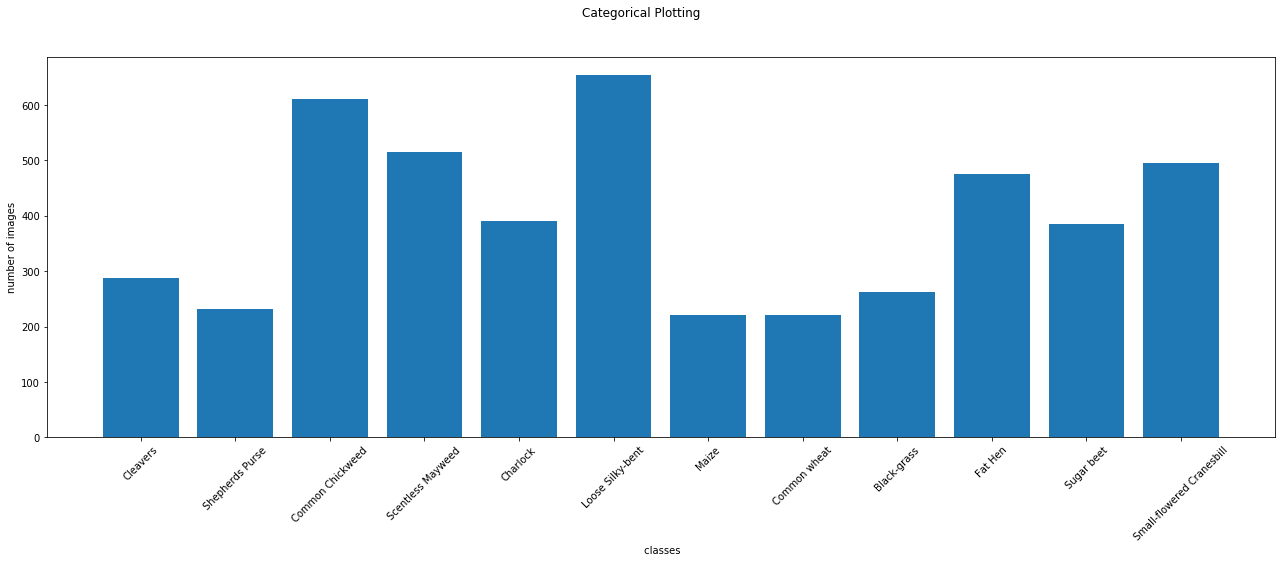

In [65]:
# Plot Distribution of number of images

values =[]
labels=[]
for label in set(classes):
  values.append(len(images[classes == label]))
  labels.append(label)

fig, ax = plt.subplots(figsize=(22,7))
plt.xticks(rotation=45)
ax.bar(labels, values)
ax.set_xlabel(" classes")
ax.set_ylabel("number of images")
#axs[1].scatter(label, )
  #axs[2].plot(names, values)
fig.suptitle('Categorical Plotting')

***## There is a lot of imbalance in the data set.***

In [0]:
# Plot Images for couple of Labels

def plot_for_class(label):
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =images[classes== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1

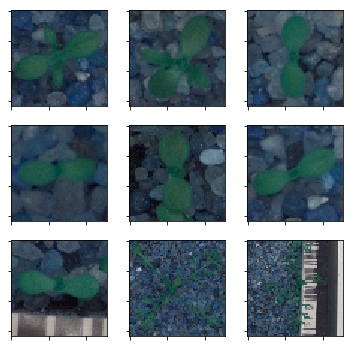

In [67]:
plot_for_class("Scentless Mayweed")

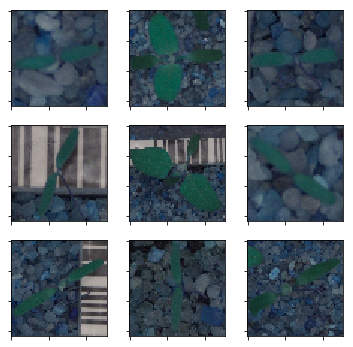

In [68]:
plot_for_class("Fat Hen")

# Image Preprocessing
    Converting RGB to HSV, then apply image segmentation and sharpening

In [0]:
# Create a sharpen filter

def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp
  
def preprocess(image):
    image_segmented = segment_plant(image)
    image_sharpen = sharpen_image(image_segmented)
    return image_sharpen

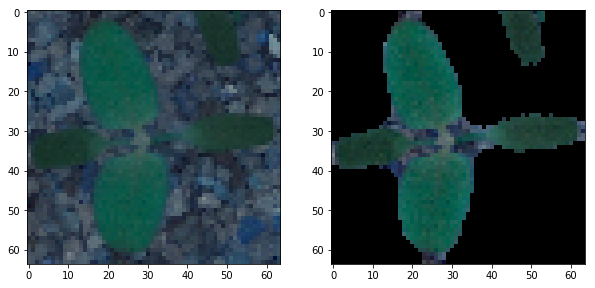

In [70]:
# Plot Original vs Preprocessed Image

image = images[classes == "Fat Hen"][1]
processed_image = preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image)
axs[1].imshow(processed_image)

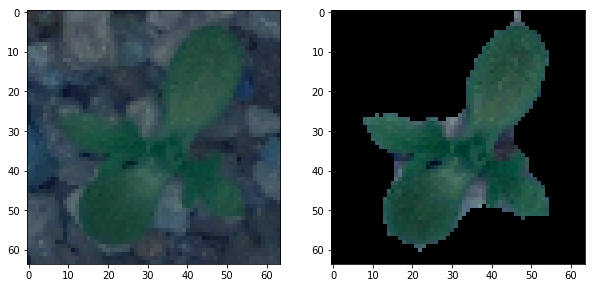

In [71]:
image = images[classes == "Scentless Mayweed"][1]
processed_image = preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image)
axs[1].imshow(processed_image)

In [0]:
# Preprocess Training data

for indx, image in enumerate(images):
  try:
     images[indx] = preprocess(image)
      
  except:
    print(indx)
    continue

# Train Validation Split

In [0]:
# Do One Hot Encoding for Classes


enc = LabelBinarizer()
labels = enc.fit_transform(classes)

In [74]:
labels[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [0]:
# Split data to train and test. Then split train to train and validation set


images = images/255.
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=seed, stratify=labels)

In [76]:
print(X_train.shape)
print(X_val.shape)

(3800, 64, 64, 3)
(950, 64, 64, 3)


# Build and Fit Model with Data Augmentation

In [86]:
# Build Model

np.random.seed(seed)

batch_size = None

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(labels.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 60, 60, 64)        4864      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 60, 60, 64)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 60, 60, 64)        256       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 56, 56, 64)        102464    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 56, 56, 64)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 28, 28, 64)       

In [0]:
# Data Augmentation

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


datagen.fit(X_train)

In [0]:
# Create callback for reducing learning rate on plateaus, define epochs and batch size

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

filepath="/content/competitions/plant-seedlings-classification/weights/weights.best_weights.hdf5"
checkpoints = ModelCheckpoint(filepath, monitor='val_acc', 
                              verbose=1, save_best_only=True, mode='max')
filepath="/content/competitions/plant-seedlings-classification/weights/weights.last_weights.hdf5"
checkpoints_full = ModelCheckpoint(filepath, monitor='val_acc', 
                                 verbose=1, save_best_only=False, mode='max')

callback_list = [checkpoints, learning_rate_reduction, checkpoints_full]
epochs = 40
batch_size = 32

In [90]:
# Fit model

history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=32),
                              epochs = 40, validation_data = (X_val,y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=callback_list)

Epoch 1/40
 - 11s - loss: 1.8835 - acc: 0.4027 - val_loss: 1.6102 - val_acc: 0.5053

Epoch 00001: val_acc improved from 0.29158 to 0.50526, saving model to /content/competitions/plant-seedlings-classification/weights/weights.best_weights.hdf5

Epoch 00001: saving model to /content/competitions/plant-seedlings-classification/weights/weights.last_weights.hdf5
Epoch 2/40
 - 11s - loss: 1.6422 - acc: 0.4490 - val_loss: 1.3318 - val_acc: 0.5600

Epoch 00002: val_acc improved from 0.50526 to 0.56000, saving model to /content/competitions/plant-seedlings-classification/weights/weights.best_weights.hdf5

Epoch 00002: saving model to /content/competitions/plant-seedlings-classification/weights/weights.last_weights.hdf5
Epoch 3/40
 - 11s - loss: 1.4066 - acc: 0.5249 - val_loss: 2.1859 - val_acc: 0.4758

Epoch 00003: val_acc did not improve from 0.56000

Epoch 00003: saving model to /content/competitions/plant-seedlings-classification/weights/weights.last_weights.hdf5
Epoch 4/40
 - 11s - loss: 1.

In [92]:
history1 = model.fit_generator(datagen.flow(X_train,y_train, batch_size=32),
                              epochs = 10, validation_data = (X_val,y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=callback_list)

Epoch 1/10
 - 11s - loss: 0.4311 - acc: 0.8543 - val_loss: 0.3238 - val_acc: 0.8821

Epoch 00001: val_acc improved from 0.88000 to 0.88211, saving model to /content/competitions/plant-seedlings-classification/weights/weights.best_weights.hdf5

Epoch 00001: saving model to /content/competitions/plant-seedlings-classification/weights/weights.last_weights.hdf5
Epoch 2/10
 - 11s - loss: 0.4289 - acc: 0.8520 - val_loss: 0.3180 - val_acc: 0.8768

Epoch 00002: val_acc did not improve from 0.88211

Epoch 00002: saving model to /content/competitions/plant-seedlings-classification/weights/weights.last_weights.hdf5
Epoch 3/10
 - 11s - loss: 0.4355 - acc: 0.8490 - val_loss: 0.3296 - val_acc: 0.8758

Epoch 00003: val_acc did not improve from 0.88211

Epoch 00003: saving model to /content/competitions/plant-seedlings-classification/weights/weights.last_weights.hdf5
Epoch 4/10
 - 11s - loss: 0.4413 - acc: 0.8462 - val_loss: 0.3308 - val_acc: 0.8779

Epoch 00004: val_acc did not improve from 0.88211



# Save and Evaluate Model

In [93]:
# Save Model for future development

def save_model(model):
    if not os.path.exists('/content/competitions/plant-seedlings-classification/model'):
        os.makedirs('/content/competitions/plant-seedlings-classification/model')
    model_json = model.to_json()
    with open("/content/competitions/plant-seedlings-classification/model/model.json", "w") as model_file:
        model_file.write(model_json)

    print('Model saved')
    return
save_model(model)

Model saved


In [94]:
# Evaluate Model

scores = model.evaluate(X_train, y_train, verbose=0)
print("Train Accuracy: %.2f%%" % (scores[1]*100))
scores = model.evaluate(X_val, y_val, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

Train Accuracy: 89.68%
Test Accuracy: 88.32%


In [95]:
# Confusion Matrix

y_pred = model.predict(X_val)
y_class = np.argmax(y_pred, axis = 1) 
y_check = np.argmax(y_val, axis = 1) 

cmatrix = confusion_matrix(y_check, y_class)
print(cmatrix)

[[  0   0   0   0   6   0  46   0   1   0   0   0]
 [  0  76   0   0   0   1   0   0   0   0   0   1]
 [  0   5  51   0   0   0   0   0   0   0   2   0]
 [  0   0   0 117   0   0   0   0   1   1   1   2]
 [  2   0   1   0  30   0  11   0   0   0   0   0]
 [  0   0   2   1   0  91   1   0   0   0   0   0]
 [  0   0   0   0   3   0 126   0   2   0   0   0]
 [  0   0   0   0   0   0   0  43   0   0   0   1]
 [  0   0   0   0   0   0   0   0 101   1   0   1]
 [  0   0   0   1   0   1   0   0  10  34   0   0]
 [  0   0   0   0   0   0   1   1   1   0  96   0]
 [  0   1   0   1   0   0   0   0   0   1   0  74]]


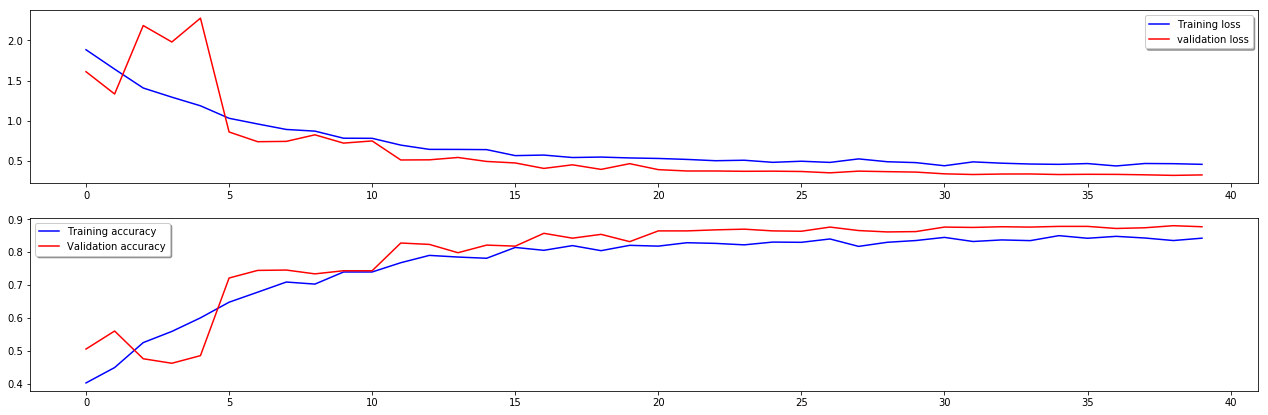

In [96]:
# Plot Loss and Accuracy Graph

fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### **We can observe the accuracy and loss saturation for both train and validation data around 25-30 epochs.**

# Observations

### After training the images using 3 conv and 2 dense layers, we achieved a decent accuracy even without using transfer learning. Some of the factors that may have assisted in reaching such accuracy are :



### 1.   Pre processing image using segmentation method.
### 2.   Normalize images between 0-1 and stratify split.
### 3.   Data Augmentation
### 4.   Using Batch Normalization, DropOut and Leaky Relu instead of Relu
### 5.   Adam Optimizer and Learning Rate Reduction

### Future Work

### 1.   Use transfer learning from established models like ResNet, Inception etc with early frozen layers followed by own architecture and tuning.
### 2.   As there is a lot of data imbalance, we can use sampling techniques like Synthetic Minority Over-sampling Technique (SMOTE) to undersample majority classes and oversample minority classes.
### 3.  Use techniques like Snapshot Ensembling along with Cyclical learning rates fr better optimization and accuracy.